In [1]:
import requests
from bs4 import BeautifulSoup

# send a request to the website
page = requests.get("https://www.lazada.co.th/products/civet-home-i397678497-s772762671.html?spm=a2o4m.home.flashSale.2.4ccd515fapRAQ5&search=1&mp=1&c=fs&clickTrackInfo=%7B%22rs%22%3A%220.047339800426754286%22%2C%22prior_score%22%3A%220%22%2C%22submission_discount%22%3A%2269%25%22%2C%22iss%22%3A%220.047339800426754286%22%2C%22rmc%22%3A%2213%22%2C%22type%22%3A%22entrance%22%2C%22prior_type%22%3A%22racing%22%2C%22userid%22%3A%22%22%2C%22sca%22%3A%2213%22%2C%22hourtonow%22%3A%2213%22%2C%22abid%22%3A%22155069%22%2C%22itemid%22%3A%22397678497_0_racing_0.047339800426754286_0.047339800426754286%22%2C%22pvid%22%3A%22308400c6-4dbb-4267-b9ff-fb4e28d412f2%22%2C%22pos%22%3A%220%22%2C%22rms%22%3A%220.04642857142857143%22%2C%22c2i%22%3A%220.0%22%2C%22scm%22%3A%221007.17760.155069.%22%2C%22ss%22%3A%220.047339800426754286%22%2C%22i2i%22%3A%220.0%22%2C%22ms%22%3A%220.047339800426754286%22%2C%22itr%22%3A%220.06%22%2C%22mt%22%3A%22racing%22%2C%22its%22%3A%221000%22%2C%22promotion_price%22%3A%22275.00%22%2C%22anonid%22%3A%22bac1217b-70ca-40ce-823c-bea3d89583a1%22%2C%22FinalScore%22%3A%220.0660406%22%2C%22isc%22%3A%2260%22%2C%22iss2%22%3A%220.5497581485290549%22%2C%22iss1%22%3A%220.03397508493771234%22%2C%22config%22%3A%22%22%2C%22HP_score%22%3A%220.0660406%22%7D&scm=1007.17760.155069.0")

# Use BeautifulSoup to parse HTML using html5 protocol. It is slower
# but more efficient 
page_content = BeautifulSoup(page.text, "html5lib")

In [21]:
# import library
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import xlsxwriter

import pythainlp
import pythaispell
from gingerit.gingerit import GingerIt
from langdetect import detect
import nltk
from keras import *
from keras.utils import to_categorical
from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords
from pythainlp.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.corpus import words
from stop_words import get_stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from pythainlp.corpus.common import thai_words
from pythainlp.tokenize import dict_trie
from pythainlp.tag.named_entity import ThaiNameTagger
from pythainlp.word_vector import get_model
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split



In [22]:
# Try entity extraction from hand-labeld data

# import data from Excel
df = pd.read_excel('./Data/Sheet0_token_test.xlsx',sheet_name=None)
df

OrderedDict([('Sheet1',       No  idx                word   pos tag
              0      0    0  SmartphonesSAMSUNG  NCMN   O
              1      1    0              Galaxy  NCMN   O
              2      2    0                   A  NCMN   O
              3      3    0                  20  DCNM   O
              4      4    0                   s  NCMN   O
              ..   ...  ...                 ...   ...  ..
              769  769    4             Battery  NCMN   O
              770  770    4            Capacity  NCMN   O
              771  771    4                3000  NCNM   O
              772  772    4                3999  NCNM   O
              773  773    4                 mAh  CMTR   O
              
              [774 rows x 5 columns])])

In [23]:
data = df['Sheet1']
data

,No,idx,word,pos,tag
0,0,0,SmartphonesSAMSUNG,NCMN,O
1,1,0,Galaxy,NCMN,O
2,2,0,A,NCMN,O
3,3,0,20,DCNM,O
4,4,0,s,NCMN,O
...,...,...,...,...,...
769,769,4,Battery,NCMN,O
770,770,4,Capacity,NCMN,O
771,771,4,3000,NCNM,O
772,772,4,3999,NCNM,O


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774 entries, 0 to 773
Data columns (total 5 columns):
No      774 non-null int64
idx     774 non-null int64
word    774 non-null object
pos     774 non-null object
tag     774 non-null object
dtypes: int64(2), object(3)
memory usage: 30.4+ KB


In [25]:
data = data.drop('No',axis=1)

In [26]:
words = list(set(data["word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

243

In [27]:
tags = list(set(data["tag"].values))
n_tags = len(tags); n_tags

5

In [28]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["word"].values.tolist(),
                                                           s["pos"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

In [29]:
getter = SentenceGetter(data)
sent = getter.get_next()
print(sent)

[('SmartphonesSamsung', 'NCMN', 'O'), ('A', 'NCMN', 'O'), ('30', 'NCNM', 'O'), ('Ram', 'PUNC', 'B-ATTR'), ('464', 'NCNM', 'B-VAL'), ('GB', 'NCMN', 'I-VAL'), ('เครื่อง', 'CNIT', 'O'), ('ศูนย์', 'DCNM', 'O'), ('ไทย', 'NPRP', 'O'), ('ประกัน', 'VSTA', 'O'), ('ศูนย์', 'DCNM', 'O'), ('1', 'DCNM', 'O'), ('ปี', 'CMTR', 'O'), ('สมาร์ท', 'CNIT', 'O'), ('โฟน', 'NCMN', 'O'), ('โทรศัพท์มือถือ', 'NCMN', 'O'), ('ระบบปฏิบัติการ', 'NCMN', 'O'), ('จอแสดงผล', 'VACT', 'B-ATTR'), ('Super', 'NCMN', 'B-VAL'), ('AMOLED', 'NCMN', 'I-VAL'), ('24', 'NCNM', 'I-VAL'), ('bit', 'CMTR', 'I-VAL'), ('16', 'DCNM', 'O'), ('ล้าน', 'CNIT', 'O'), ('สี', 'CNIT', 'O'), ('หน้าจอ', 'NCMN', 'O'), ('หยดน้ำ', 'NCMN', 'O'), ('รูป', 'NCMN', 'O'), ('ตัว', 'CNIT', 'O'), ('U', 'NCMN', 'O'), ('Infinity', 'NCMN', 'O'), ('U', 'NCMN', 'O'), ('ระบบ', 'NCMN', 'O'), ('สัมผัส', 'VACT', 'O'), ('MultiTouch', 'NCMN', 'O'), ('6.4', 'NCNM', 'I-VAL'), ('นิ้ว', 'CMTR', 'I-VAL'), ('แนว', 'NCMN', 'O'), ('ทะแยง', 'NCMN', 'O'), ('ละเอียด', 'VATT', 'O'), 

In [30]:
sentences = getter.sentences

In [31]:
max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [32]:
from keras.preprocessing.sequence import pad_sequences

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

y = [to_categorical(i, num_classes=n_tags) for i in y]

In [33]:
# Split data into train and test set
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

In [48]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF


x = layers.Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=max_len)(x)  # 20-dim embedding
model = Bidirectional(LSTM(units=32, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(32, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

model = Model(x, out)

In [49]:
model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()

C:\Users\super\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
C:\Users\super\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 75, 20)            4880      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 75, 64)            13568     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 75, 32)            2080      
_________________________________________________________________
crf_5 (CRF)                  (None, 75, 5)             200       
Total params: 20,728
Trainable params: 20,728
Non-trainable params: 0
_________________________________________________________________


In [50]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5,
                    validation_split=0.1, verbose=1)

C:\Users\super\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3 samples, validate on 1 samples
Epoch 1/5
3/3 [==============================] - 2s 626ms/step - loss: 1.1930 - crf_viterbi_accuracy: 0.6222 - val_loss: 0.9189 - val_crf_viterbi_accuracy: 0.8667
Epoch 2/5
3/3 [==============================] - 0s 142ms/step - loss: 1.1880 - crf_viterbi_accuracy: 0.6222 - val_loss: 0.9113 - val_crf_viterbi_accuracy: 0.8667
Epoch 3/5
3/3 [==============================] - 0s 142ms/step - loss: 1.1828 - crf_viterbi_accuracy: 0.6222 - val_loss: 0.9031 - val_crf_viterbi_accuracy: 0.8667
Epoch 4/5
3/3 [==============================] - 0s 139ms/step - loss: 1.1773 - crf_viterbi_accuracy: 0.6222 - val_loss: 0.8944 - val_crf_viterbi_accuracy: 0.8667
Epoch 5/5
3/3 [==============================] - 0s 144ms/step - loss: 1.1708 - crf_viterbi_accuracy: 0.6222 - val_loss: 0.8849 - val_crf_viterbi_accuracy: 0.8667


In [52]:
def plot_history(history):
    
    f, ax = plt.subplots(1, 2, figsize = (16, 7))
    
    acc = history.history['crf_viterbi_accuracy']
    val_acc = history.history['val_crf_viterbi_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.sca(ax[0])
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.sca(ax[1])
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

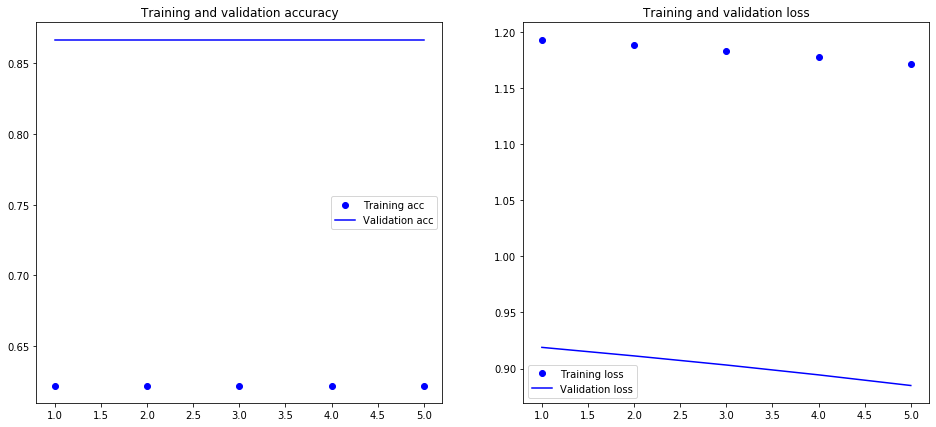

In [53]:
plot_history(history)

In [54]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

test_pred = model.predict(X_te, verbose=1)


1/1 [==============================] - 0s 345ms/step


In [55]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)

In [56]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
print(classification_report(test_labels, pred_labels))

F1-score: 0.0%
           precision    recall  f1-score   support

     ATTR       0.00      0.00      0.00         8
      VAL       0.00      0.00      0.00         8

micro avg       0.00      0.00      0.00        16
macro avg       0.00      0.00      0.00        16



In [57]:
i = 0
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)
print("{:15}||{:5}||{}".format("word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))

word           ||True ||Pred
ล็อค           : O     O
สแกน           : O     O
ใบหน้า         : O     O
รองรับ         : O     O
2              : O     O
SIM            : O     O
พอร์ท          : O     O
MicroUSB       : O     O
แบตเตอรี่      : B-ATTR O
3400           : B-VAL O
mAh            : I-VAL O
ระบบ           : B-ATTR O
Android        : B-VAL O
9.0            : I-VAL O
One            : O     O
UI             : O     O
ขนาด           : B-ATTR O
ตัว            : I-ATTR O
เครื่อง        : I-ATTR O
155.6          : B-VAL O
x              : I-VAL O
75.6           : I-VAL O
x              : I-VAL O
7.94           : I-VAL O
มม.            : I-VAL O
สี             : O     O
วาง            : O     O
จำหน่าย        : O     O
สีแดง          : O     O
น้ำเงิน        : O     O
ดำ             : O     O
แบรนด์         : B-ATTR O
ซัมซุง         : B-VAL O
ประเภท         : O     O
การรับประกัน   : O     O
การรับประกัน   : O     O
โรงงาน         : O     O
ในประเทศ       : O     O
กล้อง          